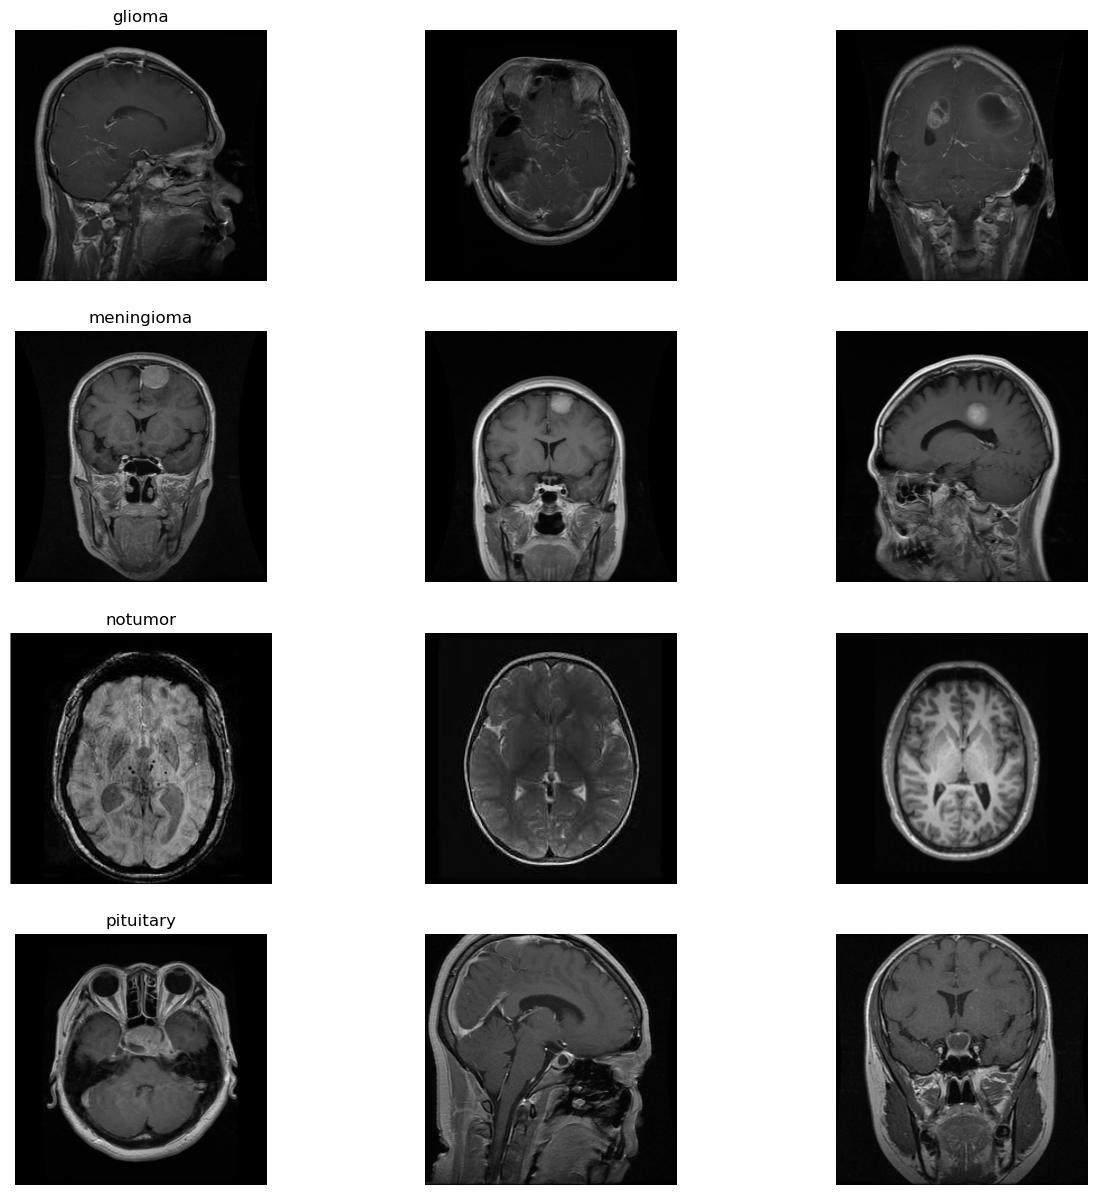

In [3]:
import matplotlib.pyplot as plt
import cv2
import random
import os

import pandas as pd


# Function to display sample images from each category
def display_sample_images(directory, categories, num_samples=3):
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 15))
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        image_files = os.listdir(category_path)
        random_samples = random.sample(image_files, num_samples)
        for j, sample in enumerate(random_samples):
            image_path = os.path.join(category_path, sample)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)
    plt.show()



training_dir = 'Training'
training_contents = ['glioma', 'meningioma', 'notumor', 'pituitary']
# Display sample images from the Training directory
display_sample_images(training_dir, training_contents)


In [4]:
import numpy as np

# Function to preprocess images
def preprocess_images(directory, categories, img_size=(128, 128)):
    preprocessed_images = []
    labels = []
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        image_files = os.listdir(category_path)
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            # Read the image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Resize the image
            resized_image = cv2.resize(image, img_size)
            # Normalize the image
            normalized_image = resized_image / 255.0
            # Apply Gaussian blur
            blurred_image = cv2.GaussianBlur(normalized_image, (5, 5), 0)
            # Append the preprocessed image and label
            preprocessed_images.append(blurred_image)
            labels.append(i)
    return np.array(preprocessed_images), np.array(labels)

# Preprocess the training images
img_size = (128, 128)
preprocessed_images, labels = preprocess_images(training_dir, training_contents, img_size)

# Confirm the shape of the preprocessed images and labels arrays
preprocessed_images.shape, labels.shape


((5712, 128, 128), (5712,))

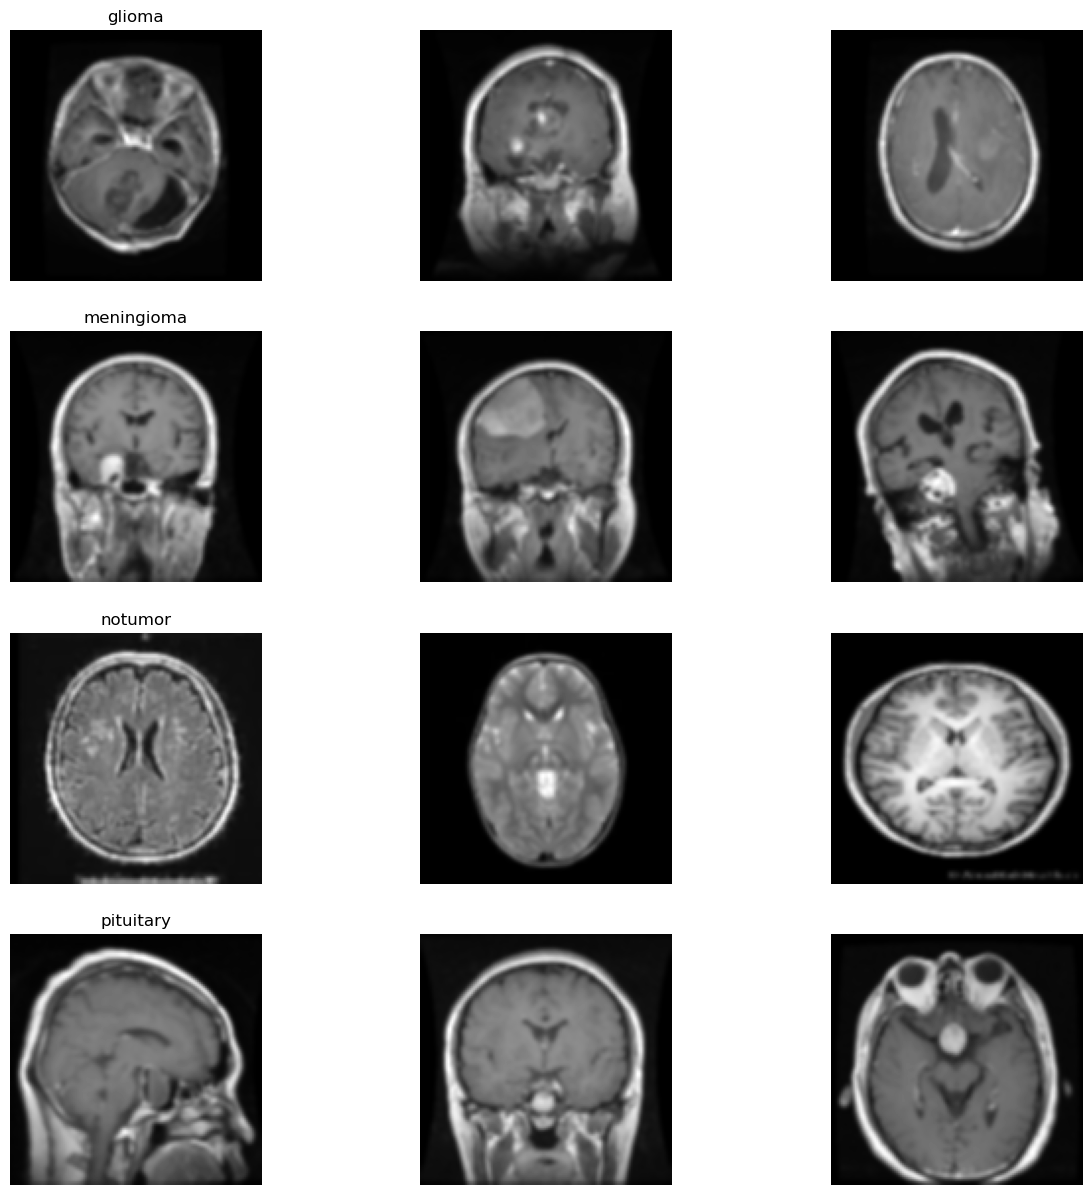

In [5]:
# Function to display sample preprocessed images from each category
def display_preprocessed_samples(images, labels, categories, num_samples=3):
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 15))
    for i, category in enumerate(categories):
        idxs = np.where(labels == i)[0]
        random_samples = np.random.choice(idxs, num_samples, replace=False)
        for j, sample in enumerate(random_samples):
            image = images[sample]
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)
    plt.show()

# Display sample preprocessed images from the Training directory
display_preprocessed_samples(preprocessed_images, labels, training_contents)


In [6]:
# Flatten the preprocessed images
flattened_images = preprocessed_images.reshape(preprocessed_images.shape[0], -1)

# Confirm the shape of the flattened images array
flattened_images.shape


(5712, 16384)

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(flattened_images, labels, test_size=0.2, random_state=42)

# Confirm the shape of the training and validation sets
X_train.shape, X_val.shape, y_train.shape, y_val.shape


((4569, 16384), (1143, 16384), (4569,), (1143,))

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the k-NN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=3)

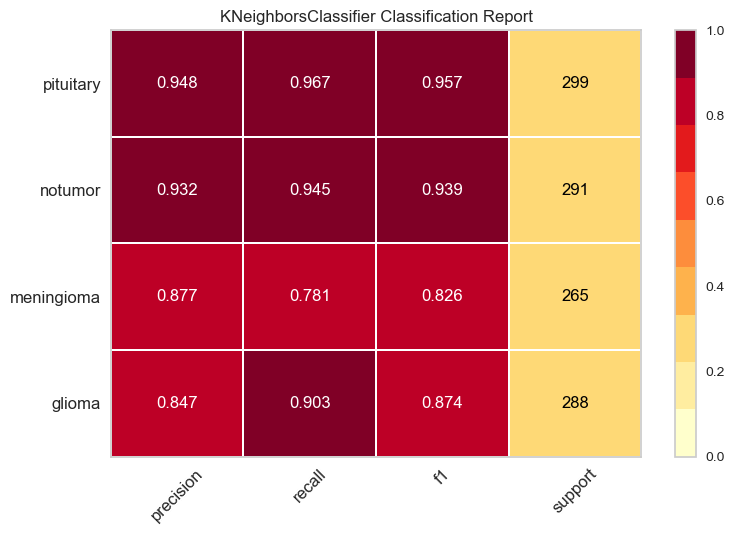

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

In [9]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(knn, classes=training_contents, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()     

In [10]:
# Preprocess the test images
test_dir = 'Testing'
training_contents = ['glioma', 'meningioma', 'notumor', 'pituitary']

preprocessed_test_images, test_labels = preprocess_images(test_dir, training_contents, img_size)



# Confirm the shape of the preprocessed test images and labels arrays

preprocessed_test_images.shape, test_labels.shape

((1311, 128, 128), (1311,))

In [11]:
# Flatten the preprocessed test images
flattened_test_images = preprocessed_test_images.reshape(preprocessed_test_images.shape[0], -1)

# Confirm the shape of the flattened test images array
flattened_test_images.shape


(1311, 16384)

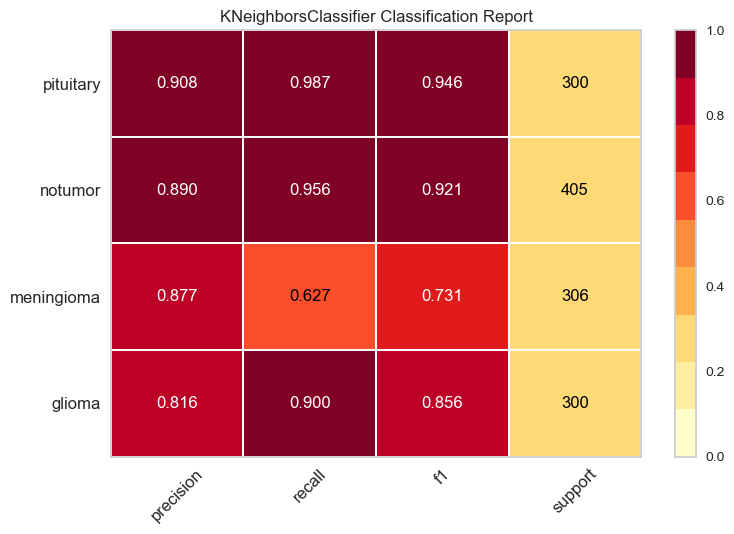

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

In [12]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(knn, classes=training_contents, support=True)

visualizer.fit(flattened_images, labels)        # Fit the visualizer and the model
visualizer.score(flattened_test_images, test_labels)        # Evaluate the model on the test data
visualizer.show()

### Convolutional Neural Netowrk (CNN)

In [13]:
from tensorflow.keras.utils import to_categorical

# Reshape the image arrays to include the channel dimension (required by Keras)
X_train_cnn = preprocessed_images.reshape(preprocessed_images.shape[0], img_size[0], img_size[1], 1)
X_test_cnn = preprocessed_test_images.reshape(preprocessed_test_images.shape[0], img_size[0], img_size[1], 1)

# One-hot encode the labels
y_train_cnn = to_categorical(labels)
y_test_cnn = to_categorical(test_labels)

# Confirm the shape of the reshaped arrays and one-hot encoded labels
X_train_cnn.shape, X_test_cnn.shape, y_train_cnn.shape, y_test_cnn.shape


((5712, 128, 128, 1), (1311, 128, 128, 1), (5712, 4), (1311, 4))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the CNN model
model = Sequential()

# Add convolutional layer with 32 filters, kernel size of 3x3, activation function ReLU
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))

# Add max pooling layer with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 filters
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the 2D array to 1D array
model.add(Flatten())

# Add a fully connected layer with 128 units and activation function ReLU
model.add(Dense(128, activation='relu'))

# Add a dropout layer with rate 0.5
model.add(Dropout(0.5))

# Add output layer with 4 units (corresponding to 4 classes) with activation function softmax
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_split=0.2)


2023-11-03 22:25:56.694234: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-03 22:25:56.694264: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-03 22:25:56.694268: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-03 22:25:56.694526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-03 22:25:56.694942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-11-03 22:25:57.372986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


143/143 [==============================] - 6s 23ms/step - loss: 0.8975 - accuracy: 0.6349 - val_loss: 1.6747 - val_accuracy: 0.2021
Epoch 2/10
143/143 [==============================] - 3s 19ms/step - loss: 0.5863 - accuracy: 0.7781 - val_loss: 1.4363 - val_accuracy: 0.3535
Epoch 3/10
143/143 [==============================] - 3s 18ms/step - loss: 0.4717 - accuracy: 0.8234 - val_loss: 0.7330 - val_accuracy: 0.7725
Epoch 4/10
143/143 [==============================] - 3s 18ms/step - loss: 0.3860 - accuracy: 0.8702 - val_loss: 0.6553 - val_accuracy: 0.8040
Epoch 5/10
143/143 [==============================] - 3s 18ms/step - loss: 0.3472 - accuracy: 0.8812 - val_loss: 0.9947 - val_accuracy: 0.7130
Epoch 6/10
143/143 [==============================] - 3s 18ms/step - loss: 0.3427 - accuracy: 0.8873 - val_loss: 0.8969 - val_accuracy: 0.7743
Epoch 7/10
143/143 [==============================] - 3s 18ms/step - loss: 0.2849 - accuracy: 0.9068 - val_loss: 1.0688 - val_accuracy: 0.7655
Epoch 8/10

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the CNN model
model = Sequential()

# Add convolutional layer with 32 filters, kernel size of 3x3, activation function ReLU
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))

# Add max pooling layer with pool size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 filters
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the 2D array to 1D array
model.add(Flatten())

# Add a fully connected layer with 128 units and activation function ReLU
model.add(Dense(128, activation='relu'))

# Add a dropout layer with rate 0.5
model.add(Dropout(0.5))

# Add output layer with 4 units (corresponding to 4 classes) with activation function softmax
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_split=0.2)


2023-11-03 22:25:56.694234: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-03 22:25:56.694264: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-03 22:25:56.694268: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-03 22:25:56.694526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-03 22:25:56.694942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-11-03 22:25:57.372986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


143/143 [==============================] - 6s 23ms/step - loss: 0.8975 - accuracy: 0.6349 - val_loss: 1.6747 - val_accuracy: 0.2021
Epoch 2/10
143/143 [==============================] - 3s 19ms/step - loss: 0.5863 - accuracy: 0.7781 - val_loss: 1.4363 - val_accuracy: 0.3535
Epoch 3/10
143/143 [==============================] - 3s 18ms/step - loss: 0.4717 - accuracy: 0.8234 - val_loss: 0.7330 - val_accuracy: 0.7725
Epoch 4/10
143/143 [==============================] - 3s 18ms/step - loss: 0.3860 - accuracy: 0.8702 - val_loss: 0.6553 - val_accuracy: 0.8040
Epoch 5/10
143/143 [==============================] - 3s 18ms/step - loss: 0.3472 - accuracy: 0.8812 - val_loss: 0.9947 - val_accuracy: 0.7130
Epoch 6/10
143/143 [==============================] - 3s 18ms/step - loss: 0.3427 - accuracy: 0.8873 - val_loss: 0.8969 - val_accuracy: 0.7743
Epoch 7/10
143/143 [==============================] - 3s 18ms/step - loss: 0.2849 - accuracy: 0.9068 - val_loss: 1.0688 - val_accuracy: 0.7655
Epoch 8/10